# 1. Варианты практического использования данных:

### - Оценка уровня риска транспортного средства (эта задача решается в данном исследовании)

### - Прогнозирование среднегодового размера страховых выплат

### - Поиск недооцененных и переоцененных транспортных средств с учетом технических характеристик и уровня риска

### - Оптимизация параметров транспортного средства с целью минимизирования совокупной стоимости владения при заданных технических характеристиках

### - Оптимизация параметров транспортного средства с целью максимизирования технических показателей при заданной совокупной стоимости владения

######  

# 2. Модель машинного обучения для оценки уровня риска транспортного средства.

### В качестве модели машинного обучения выбран Decision Tree Classifier. Поскольку данная задача является задачей много-классовой классификации со значениями {-3,-2,-1,0,1,2,3}, данная модель способна спрогнозировать один из возможных классов уровня риска на основе имеющихся объясняющих переменных. В то же время, данная модель способна выявить нелинейные зависимости в данных, а также легко интерпретируется (в отличие от более сложных моделей), и может оценить относительную важность обучающих переменных.

######  

# 3. Подход к машинному обучению.

### Предварительный анализ данных включает в себя изучение типов данных и их визуализацию с целью проверки сбалансированности выборки (не выполняется) и нормальности ее распределения (в целом выполняется).

### Полученные данные представляют собой ряд непрерывных, дискретных и категориальных переменных. Соответственно, категориальные переменные преобразуются либо в дискретные, либо в бинарные с использованием one-hot encoding.

### Следующим шагом является замещение недостающих значений. Поскольку размер выборки мал, пропущенные данные не удаляются, а оцениваются с помощью алгоритма K-Nearest Neighbors (K=3)

### Поскольку часть переменных может быть коррелирована, парная корреляция проверяется для всех переменных и, если она превышает 0.9, одна из переменных удаляется.

### Для выбора признаков используется метод Stability Selection. Данный метод настроен таким образом, чтобы выбрать около 10 наиболее значимых признаков, которые позволят оценить уровень риска транспортного средства. Ограничение количества признаков необходимо чтобы избежать переобучение модели ввиду низкого объема данных.

### Поиск оптимальных гипер-параметров модели Decision Tree Classifier осуществляется с помощью поиска на сетке параметров при стратифицированной кросс-валидации методом KFold (K = 2). В качестве метрики оценивания используется точность классификации (accuracy). Также производится балансировка данных путем присваивания весов наблюдениям.

######  

# 4. Дальнейшие направления исследования.

### В качестве тестового набора данных выделяется 15% данных с использованием стратифицированной выборки. Построенная модель машинного обучения демонстрирует точность 84% на тестовой выборке, что является весьма хорошим результатом.

### Более высокая точность классификации могла бы быть достигнута при наличии большего объема данных и при использовании более сложных моделей машинного обучения, таких как Gradient Boosting или Deep Neural Network.

######  

# Reading data

In [200]:
import pandas as pd
import numpy as np
import math as mt
import matplotlib.pyplot as pt

from fancyimpute import KNN

from sklearn.linear_model import RandomizedLogisticRegression
from sklearn.model_selection import GridSearchCV, StratifiedKFold
from sklearn.metrics import accuracy_score, make_scorer
from sklearn.tree import DecisionTreeClassifier

In [69]:
headers = ['symbol', 'loss', 'make', 'fuel_type', 'aspiration', 'num_of_doors', 'body_style', 
           'drive_wheels', 'engine_location', 'wheel_base', 'length', 'width', 'height', 'curb_weight', 
           'engine_type', 'num_of_cylinders', 'engine_size', 'fuel_system', 'bore', 'stroke', 
           'compression_ratio', 'horsepower', 'peak_rpm', 'city_mpg', 'highway_mpg', 'price']
data = pd.read_csv('https://archive.ics.uci.edu/ml/machine-learning-databases/autos/imports-85.data', 
                   header=None, names=headers, dtype=str)
data.replace('?', np.nan, inplace = True)

as_float = ['symbol', 'loss', 'wheel_base', 'length', 'width', 'height', 'curb_weight', 'engine_size', 'bore',
            'stroke', 'compression_ratio', 'horsepower', 'peak_rpm', 'city_mpg', 'highway_mpg', 'price']
data[as_float] = data[as_float].astype(float)

######  

# Exploratory data analysis

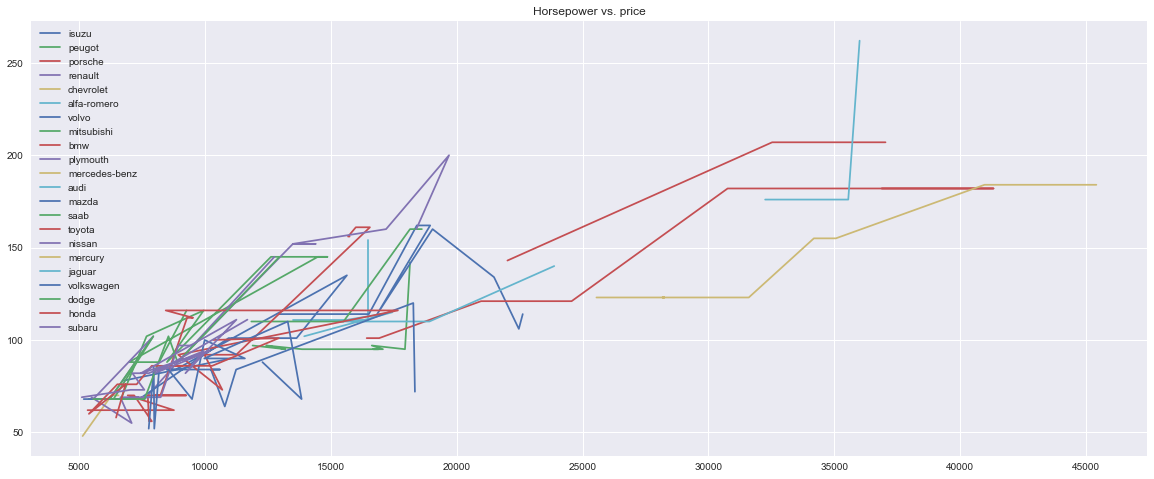

In [71]:
xvar = 'horsepower'
yvar = 'price'
makes = set(data['make'].dropna())
fig, ax = pt.subplots(figsize=(20, 8))
for make in makes:
    make_data = data[data['make'] == make][[yvar, xvar]].dropna()
    ax.plot(make_data[yvar], make_data[xvar], label = str(make))
ax.legend()
ax.set_title('Horsepower vs. price')
pt.show()

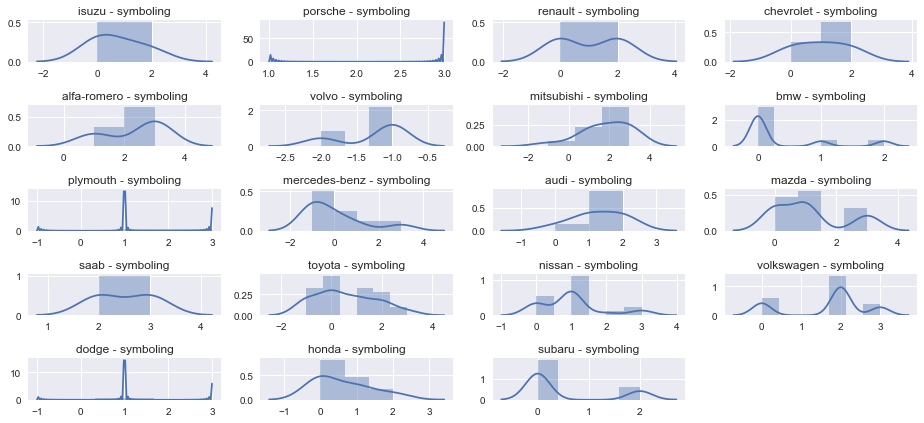

In [72]:
fg = pt.figure(figsize=(13, 7))
i = 1
for make in makes:
    make_data = data[data['make'] == make]['symbol'].dropna().astype(int)
    ax = fg.add_subplot(mt.ceil(len(makes)/4),4,i)
    if (len(set(make_data)) > 1):
        sns.distplot(make_data, ax = ax, axlabel = False)
        ax.set_title(str(make) + ' - ' + 'symboling')
        i += 1
pt.tight_layout()
pt.show()

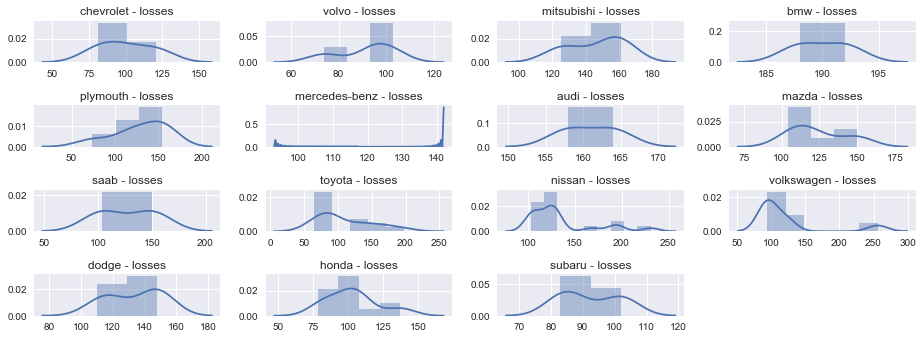

In [73]:
fg = pt.figure(figsize=(13, 7))
i = 1
for make in makes:
    make_data = data[data['make'] == make]['loss'].dropna().astype(int)
    ax = fg.add_subplot(mt.ceil(len(makes)/4),4,i)
    if (len(set(make_data)) > 1):
        sns.distplot(make_data, ax = ax, axlabel = False)
        ax.set_title(str(make) + ' - ' + 'losses')
        i += 1
pt.tight_layout()
pt.show()

######  

# Preprocessing

### Transforming categorical variables

In [74]:
word_map = {"num_of_doors":     {"four": 4, "two": 2},
            "num_of_cylinders": {"four": 4, "six": 6, "five": 5, "eight": 8, "two": 2, "twelve": 12, "three":3 }}
data = data.replace(word_map)

In [75]:
var_categories = ['make', 'fuel_type', 'aspiration', 'body_style', 
                  'drive_wheels', 'engine_location', 'engine_type', 'fuel_system']
for var in var_categories:
    Dummies = pd.get_dummies(data[var]).add_prefix(var + '_').iloc[:,1:]
    data = data.join(Dummies)
    del data[var]

### Interpolation of missing values with KNN

In [76]:
data = pd.DataFrame(KNN(k=3).complete(data), columns = data.columns)

Imputing row 1/205 with 1 missing, elapsed time: 0.029
Imputing row 101/205 with 0 missing, elapsed time: 0.031
Imputing row 201/205 with 0 missing, elapsed time: 0.032


### Reduction of collinearity

In [77]:
drop_list = []
for c1 in data.columns[2:]:
    for c2 in data.columns[2:]:
        if ((c1 != c2) and (c1 not in drop_list) and (c2 not in drop_list)):
            corr = data[[c1,c2]].corr().iloc[0,1]
            if (corr > 0.90):
                print ('Correlation between ' + c1 + ' and ' + c2 + ' is ' + str(round(corr,2)) 
                       + '. Column "' + c2 + '" will be dropped.')
                drop_list.append(c2)

for c in drop_list:
    del data[c]

Correlation between compression_ratio and fuel_system_idi is 0.98. Column "fuel_system_idi" will be dropped.
Correlation between city_mpg and highway_mpg is 0.97. Column "highway_mpg" will be dropped.
Correlation between make_peugot and engine_type_l is 0.95. Column "engine_type_l" will be dropped.


### Train / test split

In [183]:
X_train, X_test, y_train, y_test = train_test_split(data.iloc[:,2:], data['symbol'], stratify=data['symbol'], test_size=0.15)

######  

## Feature selection

In [184]:
X = X_train
Y = y_train
RL_selector = RandomizedLogisticRegression(C = 0.9)
RL = RL_selector.fit(X, Y)
Selected_features = []
Selector_support = RL.get_support()
for i in range(0, len(X.columns)):
    if (Selector_support[i]):
        Selected_features.append(X.columns[i])
        
print('Selected features:')
Selected_features

Selected features:


['num_of_doors',
 'wheel_base',
 'length',
 'height',
 'curb_weight',
 'bore',
 'city_mpg',
 'make_peugot',
 'make_volvo',
 'fuel_system_2bbl']

######  

## Implementing machine learning model


### Decision Tree Classifier

In [185]:
X = X_train[Selected_features]
Y = y_train

estm = DecisionTreeClassifier(class_weight = "balanced")
tuned_parameters = [{'min_samples_split': [2, 3, 4], 'min_samples_leaf': [1, 2, 3]}]

clf = GridSearchCV(estimator=estm, param_grid=tuned_parameters,
                   cv=StratifiedKFold(n_splits=2), scoring=make_scorer(accuracy_score))
clf.fit(X, Y)

print("Grid accuracy scores on development set:")
means = clf.cv_results_['mean_test_score']
stds = clf.cv_results_['std_test_score']
for mean, std, params in zip(means, stds, clf.cv_results_['params']):
    print("%0.3f (+/-%0.03f) for %r" % (mean, 2 * std, params))
print()
print("Best accuracy score is %0.3f." % clf.best_score_, "Best parameters set found on development set:")
print(clf.best_params_)

estm.set_params(**clf.best_params_)
estm.fit(X, Y);

Grid accuracy scores on development set:
0.713 (+/-0.079) for {'min_samples_leaf': 1, 'min_samples_split': 2}
0.695 (+/-0.066) for {'min_samples_leaf': 1, 'min_samples_split': 3}
0.667 (+/-0.100) for {'min_samples_leaf': 1, 'min_samples_split': 4}
0.638 (+/-0.018) for {'min_samples_leaf': 2, 'min_samples_split': 2}
0.621 (+/-0.052) for {'min_samples_leaf': 2, 'min_samples_split': 3}
0.626 (+/-0.006) for {'min_samples_leaf': 2, 'min_samples_split': 4}
0.621 (+/-0.006) for {'min_samples_leaf': 3, 'min_samples_split': 2}
0.626 (+/-0.006) for {'min_samples_leaf': 3, 'min_samples_split': 3}
0.626 (+/-0.006) for {'min_samples_leaf': 3, 'min_samples_split': 4}

Best accuracy score is 0.713. Best parameters set found on development set:
{'min_samples_leaf': 1, 'min_samples_split': 2}


######  

## Performance on the test dataset

In [186]:
X = X_test[Selected_features]
Y = y_test

y_pred = estm.predict(X)
score = accuracy_score(y_pred = y_pred, y_true = Y)

print ('Accuracy of classificator on the test dataset is %0.3f.' % score)

Accuracy of classificator on the test dataset is 0.839.


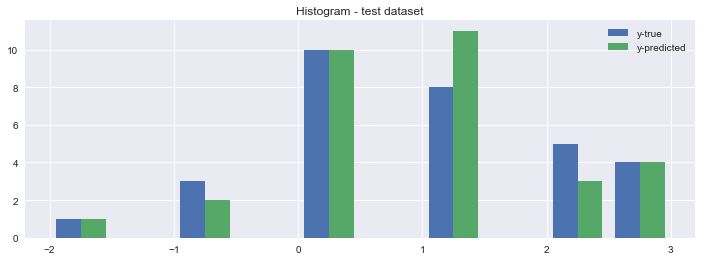

In [198]:
fg = pt.figure(figsize=(12,4))
pt.hist([Y, y_pred])
pt.legend(labels = ['y-true', 'y-predicted'])
pt.title('Histogram - test dataset')
pt.show()
print()

######  

## Importance of features

In [199]:
pd.DataFrame(estm.feature_importances_, index=Selected_features, columns=['Importance']
                                                     ).sort_values(by='Importance',  ascending=False)

,Importance
height,0.284387
wheel_base,0.194463
make_volvo,0.156803
length,0.071153
city_mpg,0.063300
curb_weight,0.062519
bore,0.056575
num_of_doors,0.051842
make_peugot,0.039768
fuel_system_2bbl,0.019189


######  